# Практика 3.3: деревья решений в `sklearn`

В предыдущих тетрадках мы:

- обсудили идею дерева решений как последовательности вопросов вида: «если признак $x_j \le t$, идём влево, иначе — вправо»;
- ввели понятие нечистоты узла (индекс Джини, энтропия);
- реализовали с нуля простое дерево решений для бинарной и многоклассовой классификации;
- увидели, как глубина дерева влияет на границу решений и переобучение.

Теперь перейдём к промышленной реализации деревьев решений в библиотеке `sklearn` и разберём:

1. Как использовать `DecisionTreeClassifier` на практике.
2. Какие есть важные гиперпараметры дерева и за что каждый отвечает.
3. Как эти гиперпараметры влияют на сложность модели и переобучение.
4. Как выбирать критерий (`gini` vs `entropy`).
5. Как использовать дополнительные настройки (минимальное число объектов в листе, ограничение числа листьев, баланс классов и т.п.).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_classification, load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

plt.rcParams["figure.figsize"] = (6, 5)
plt.rcParams["axes.grid"] = True


## 1. Базовый пример: `DecisionTreeClassifier` на нелинейном датасете

Начнём с небольшого двумерного датасета `make_moons`, который мы уже использовали для демонстрации нелинейных границ.

Цель:

- показать, как обучить дерево решений в `sklearn`;
- посмотреть на качество на обучающей и тестовой выборках;
- визуализировать границу решений дерева и сравнить её с тем, что мы делали вручную.


In [2]:
# Генерируем бинарный датасет
X, y = make_moons(n_samples=400, noise=0.25, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((280, 2), (120, 2))

In [3]:
def plot_decision_boundary(model, X, y, h=0.02, title=None):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.2)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", alpha=0.8)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    if title is not None:
        ax.set_title(title)
    plt.show()


In [4]:
# Базовое дерево с настройками по умолчанию
tree_basic = DecisionTreeClassifier(random_state=42)
tree_basic.fit(X_train, y_train)

y_pred_train = tree_basic.predict(X_train)
y_pred_test = tree_basic.predict(X_test)

print("Глубина дерева:", tree_basic.get_depth())
print("Число листьев:", tree_basic.get_n_leaves())

print("\nAccuracy (train):", accuracy_score(y_train, y_pred_train))
print("Accuracy (test): ", accuracy_score(y_test, y_pred_test))


Глубина дерева: 9
Число листьев: 24

Accuracy (train): 1.0
Accuracy (test):  0.9083333333333333


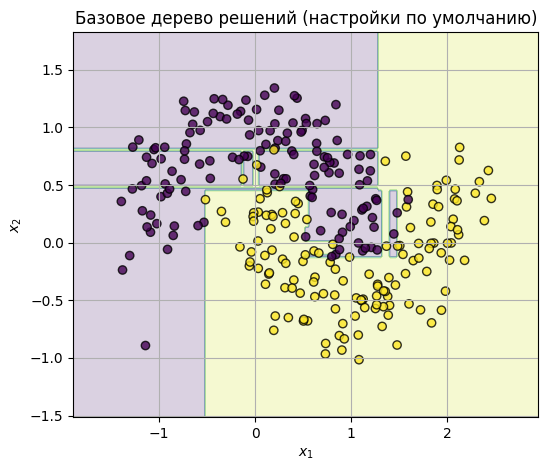

In [5]:
plot_decision_boundary(
    tree_basic, X_train, y_train,
    title="Базовое дерево решений (настройки по умолчанию)"
)


### Что означает «настройки по умолчанию»

Объект `DecisionTreeClassifier` имеет множество гиперпараметров. Если явно не задавать их значения, используются значения по умолчанию. Важные из них:

- `criterion="gini"` — по умолчанию используется индекс Джини как критерий нечистоты узла.
- `max_depth=None` — глубина дерева не ограничена и дерево растёт, пока не выполнится один из других критериев остановки.
- `min_samples_split=2` — минимальное число объектов в узле, при котором узел ещё можно разби́ть.
- `min_samples_leaf=1` — минимальное число объектов в листе.
- `max_features=None` — на каждом разбиении можно использовать все признаки.
- `random_state=None` — отсутствует фиксированное начальное состояние генератора случайных чисел.
- `class_weight=None` — все классы считаются одинаково важными.

В результате дерево по умолчанию часто получается **очень глубоким** и склонным к переобучению: оно старается почти идеально подогнаться под обучающую выборку.

Дальше мы посмотрим, как изменяется поведение дерева при регулировании этих параметров.


## 2. Критерий качества: `criterion="gini"` против `criterion="entropy"`

Мы уже обсуждали два критерия нечистоты узла:

- индекс Джини:
  $$G = 1 - \sum_k p_k^2,$$
- энтропию:
  $$H = - \sum_k p_k \log_2 p_k,$$

где $p_k$ — доля класса $k$ в узле.

В `DecisionTreeClassifier` можно выбрать один из этих критериев с помощью аргумента `criterion`.
Посмотрим, как это влияет на глубину дерева, качество и границу решений.


In [6]:
tree_gini = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)
tree_entropy = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    random_state=42
)

tree_gini.fit(X_train, y_train)
tree_entropy.fit(X_train, y_train)

y_pred_gini = tree_gini.predict(X_test)
y_pred_entropy = tree_entropy.predict(X_test)

print("Gini:")
print("  Глубина дерева:", tree_gini.get_depth())
print("  Число листьев:", tree_gini.get_n_leaves())
print("  Accuracy (test):", accuracy_score(y_test, y_pred_gini))

print("\nEntropy:")
print("  Глубина дерева:", tree_entropy.get_depth())
print("  Число листьев:", tree_entropy.get_n_leaves())
print("  Accuracy (test):", accuracy_score(y_test, y_pred_entropy))


Gini:
  Глубина дерева: 5
  Число листьев: 11
  Accuracy (test): 0.925

Entropy:
  Глубина дерева: 5
  Число листьев: 10
  Accuracy (test): 0.925


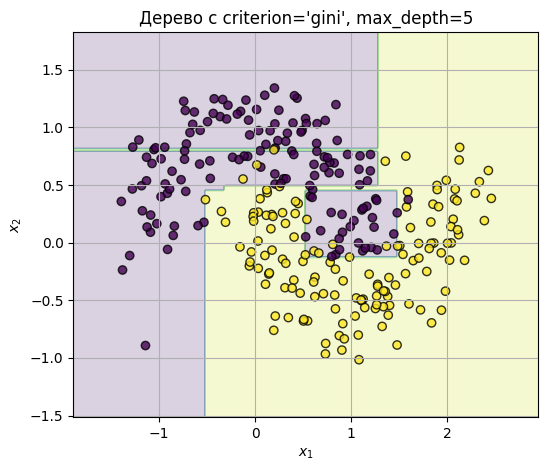

In [7]:
plot_decision_boundary(
    tree_gini, X_train, y_train,
    title="Дерево с criterion='gini', max_depth=5"
)


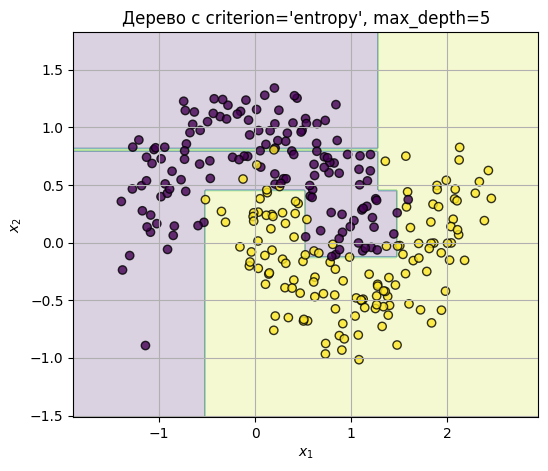

In [8]:
plot_decision_boundary(
    tree_entropy, X_train, y_train,
    title="Дерево с criterion='entropy', max_depth=5"
)


На практике деревья с `criterion="gini"` и `criterion="entropy"` часто дают очень похожие результаты:

- качество на тесте близко;
- границы решений визуально почти не отличаются;
- глубина и число листьев могут слегка различаться.

**Вывод:** выбор между Джини и энтропией обычно не является главным фактором качества модели. Часто важнее:

- глубина дерева (`max_depth`);
- число объектов в листе (`min_samples_leaf`);
- баланс классов;
- размер обучающей выборки.

Дальше сосредоточимся на тех гиперпараметрах, которые сильнее контролируют сложность дерева и переобучение.


## 3. Влияние глубины дерева: `max_depth` и переобучение

Параметр `max_depth` задаёт максимальное число уровней от корня до листа.

Интуитивно:

- при маленьком `max_depth` дерево не успевает «подстроиться» под данные — это **недообучение**;
- при большом `max_depth` дерево может запомнить почти все детали обучающей выборки — это **переобучение**.

Посмотрим, как меняются качество и граница решений при разных значениях `max_depth`.


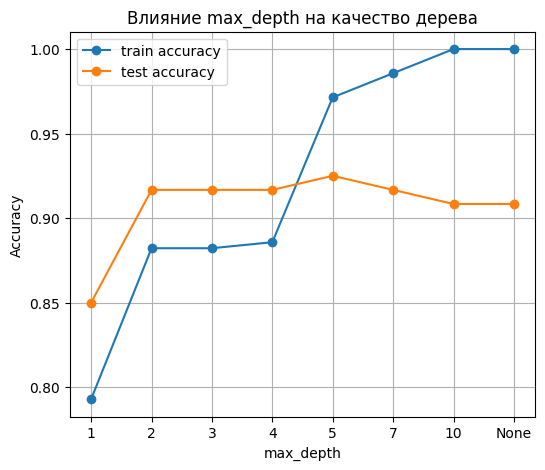

In [9]:
depths = [1, 2, 3, 4, 5, 7, 10, None]

train_scores = []
test_scores = []

for d in depths:
    tree = DecisionTreeClassifier(
        criterion="gini",
        max_depth=d,
        random_state=42
    )
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_scores.append(accuracy_score(y_train, y_train_pred))
    test_scores.append(accuracy_score(y_test, y_test_pred))

fig, ax = plt.subplots()
x_ticks = list(range(len(depths)))
labels = [str(d) for d in depths]

ax.plot(x_ticks, train_scores, marker="o", label="train accuracy")
ax.plot(x_ticks, test_scores, marker="o", label="test accuracy")
ax.set_xticks(x_ticks)
ax.set_xticklabels(labels)
ax.set_xlabel("max_depth")
ax.set_ylabel("Accuracy")
ax.set_title("Влияние max_depth на качество дерева")
ax.legend()
plt.show()


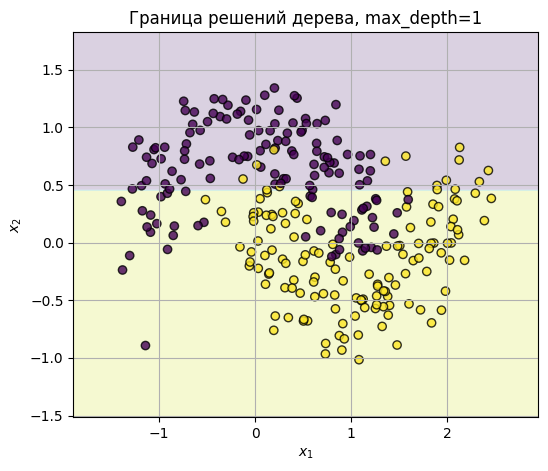

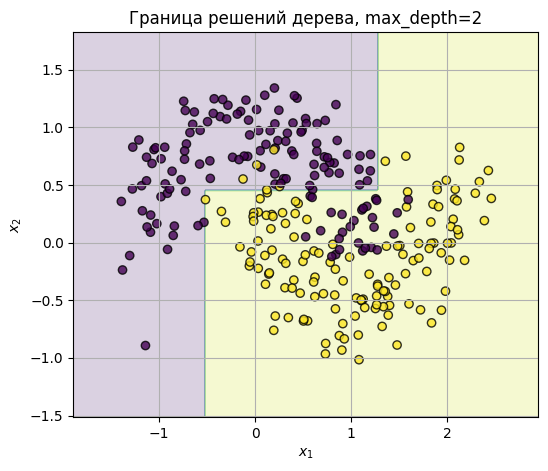

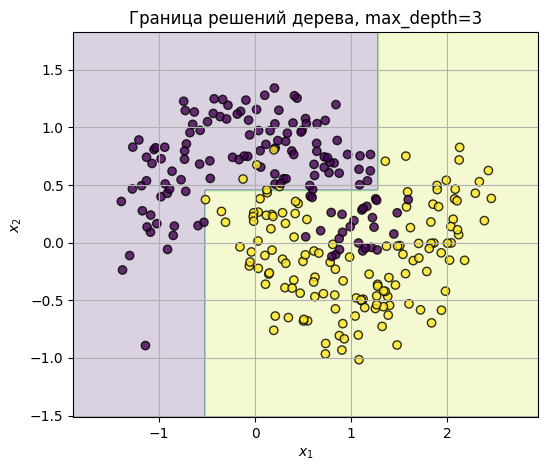

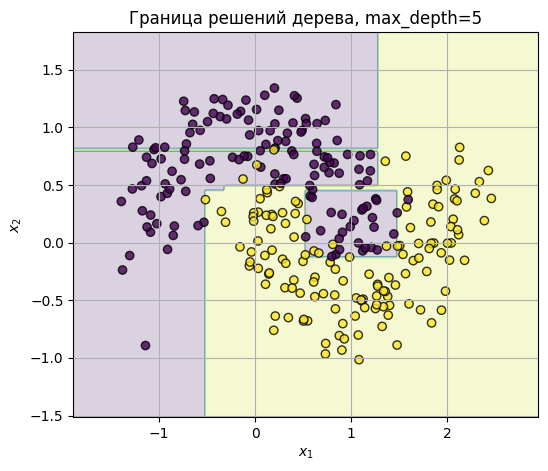

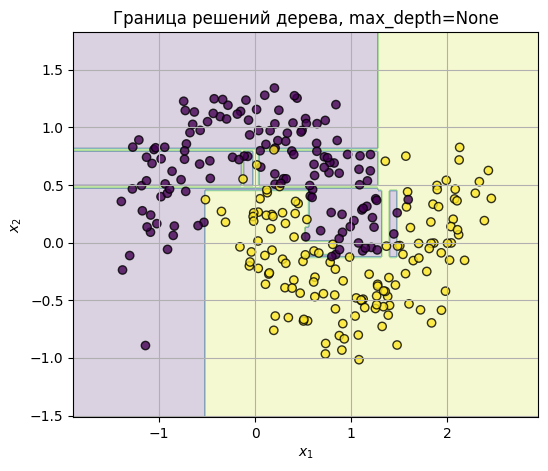

In [10]:
selected_depths = [1, 2, 3, 5, None]

for d in selected_depths:
    tree = DecisionTreeClassifier(
        criterion="gini",
        max_depth=d,
        random_state=42
    )
    tree.fit(X_train, y_train)

    title = f"Граница решений дерева, max_depth={d}"
    plot_decision_boundary(tree, X_train, y_train, title=title)


На графике с качеством видно типичное поведение:

- при маленькой глубине (например, `max_depth = 1` или `2`) дерево слишком простое, и качество на обучении и тесте низкое — **недообучение**;
- при увеличении глубины качество на обучающей выборке растёт и может становиться почти равным $1$;
- качество на тесте сначала растёт, а затем может начинать падать — **переобучение**.

На графиках границы решений:

- при маленькой глубине дерево разделяет пространство очень грубо (несколько больших прямоугольных областей);
- при большой глубине граница становится сильно «зубчатой» и подстраивается под шум в данных.

Параметр `max_depth` — один из ключевых рычагов контроля сложности дерева.


## 4. Минимальный размер узлов: `min_samples_leaf` и `min_samples_split`

Кроме глубины, на структуру дерева сильно влияют:

- `min_samples_split` — минимальное число объектов в узле, чтобы его ещё можно было разби́ть;
- `min_samples_leaf` — минимальное число объектов в листе.

Интуитивно:

- большой `min_samples_leaf` запрещает узлы с очень малым числом объектов → граница решений становится более гладкой;
- `min_samples_split` контролирует, когда дерево перестаёт разбивать узел, даже если глубина это позволяет.


min_samples_leaf = 1
  Глубина дерева: 9
  Число листьев: 24
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333



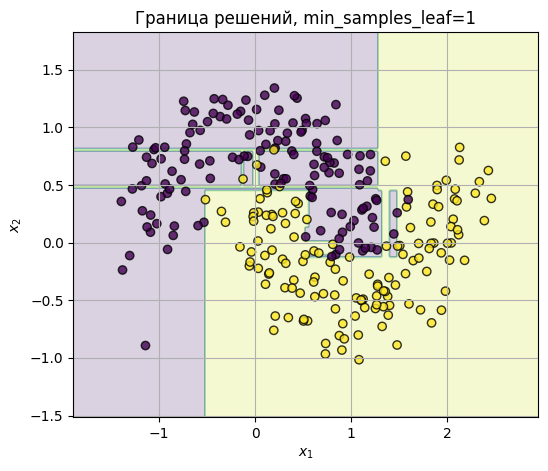

min_samples_leaf = 5
  Глубина дерева: 7
  Число листьев: 16
  Accuracy (train): 0.9678571428571429
  Accuracy (test):  0.925



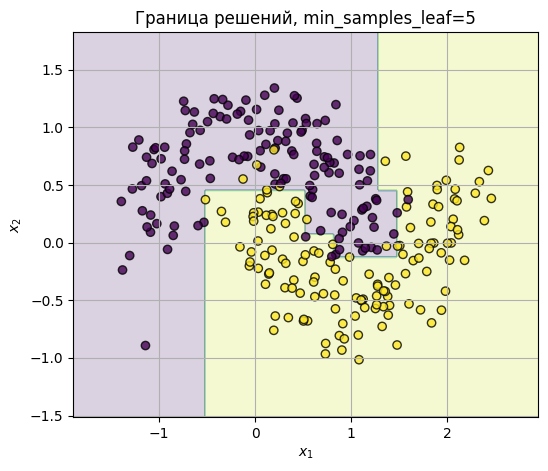

min_samples_leaf = 20
  Глубина дерева: 5
  Число листьев: 9
  Accuracy (train): 0.925
  Accuracy (test):  0.9083333333333333



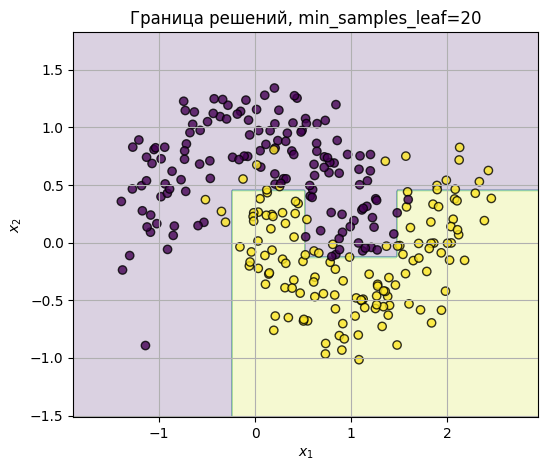

In [11]:
leaf_sizes = [1, 5, 20]

for leaf in leaf_sizes:
    tree = DecisionTreeClassifier(
        criterion="gini",
        max_depth=None,
        min_samples_leaf=leaf,
        random_state=42
    )
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    print(f"min_samples_leaf = {leaf}")
    print("  Глубина дерева:", tree.get_depth())
    print("  Число листьев:", tree.get_n_leaves())
    print("  Accuracy (train):", accuracy_score(y_train, y_train_pred))
    print("  Accuracy (test): ", accuracy_score(y_test, y_test_pred))
    print()

    title = f"Граница решений, min_samples_leaf={leaf}"
    plot_decision_boundary(tree, X_train, y_train, title=title)


Наблюдения по `min_samples_leaf`:

- при `min_samples_leaf = 1` дерево может создавать очень маленькие листья (иногда с одним объектом) — это повышает риск переобучения;
- при `min_samples_leaf = 5` или `20` дерево вынуждено объединять мелкие области и строить более гладкие границы;
- качество на тесте может улучшаться или оставаться примерно тем же, несмотря на снижение точности на обучении — это признак уменьшения переобучения.

Параметр `min_samples_split` играет похожую роль, но действует на уровне узлов, которые ещё можно разби́ть. Обычно вначале достаточно регулировать `max_depth` и `min_samples_leaf`.


## 5. Ограничение числа листьев: `max_leaf_nodes`

Ещё один способ контролировать сложность дерева — ограничить максимальное число листьев с помощью `max_leaf_nodes`.

Интуитивно:

- меньше листьев → модель проще → меньше риск переобучения;
- больше листьев → модель сложнее → выше риск переобучения, но больше гибкость.

Посмотрим на влияние `max_leaf_nodes` на нашем датасете.


max_leaf_nodes = 3
  Глубина дерева: 2
  Число листьев: 3
  Accuracy (train): 0.8535714285714285
  Accuracy (test):  0.9



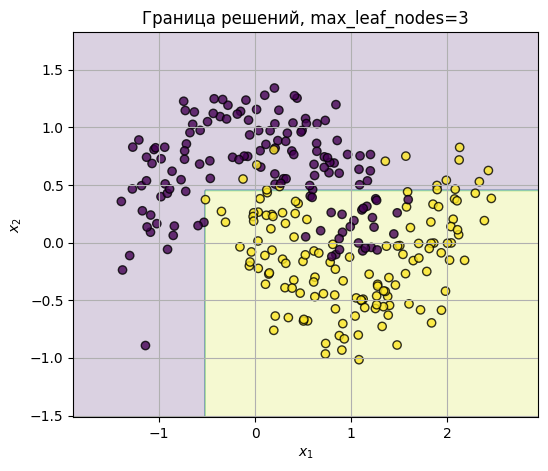

max_leaf_nodes = 5
  Глубина дерева: 3
  Число листьев: 5
  Accuracy (train): 0.8821428571428571
  Accuracy (test):  0.9166666666666666



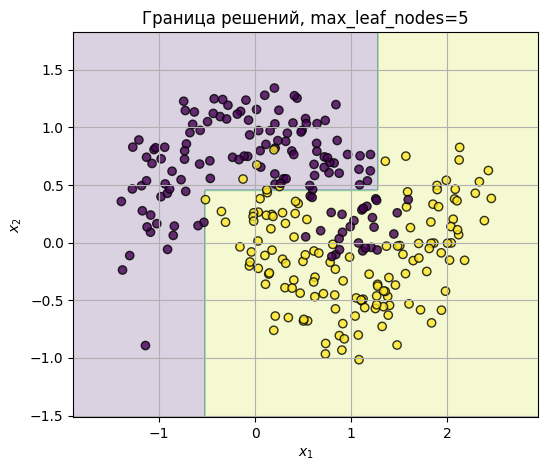

max_leaf_nodes = 10
  Глубина дерева: 8
  Число листьев: 10
  Accuracy (train): 0.975
  Accuracy (test):  0.925



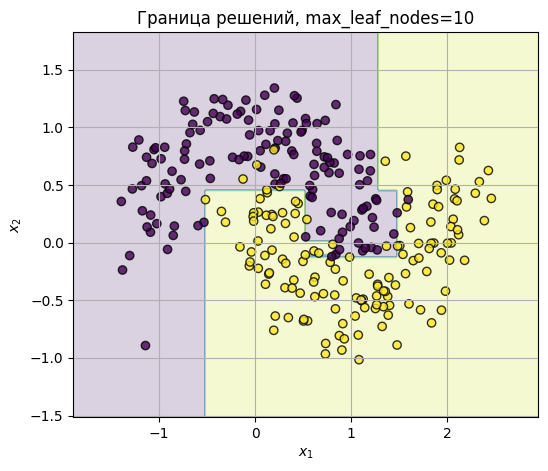

max_leaf_nodes = 30
  Глубина дерева: 9
  Число листьев: 24
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333



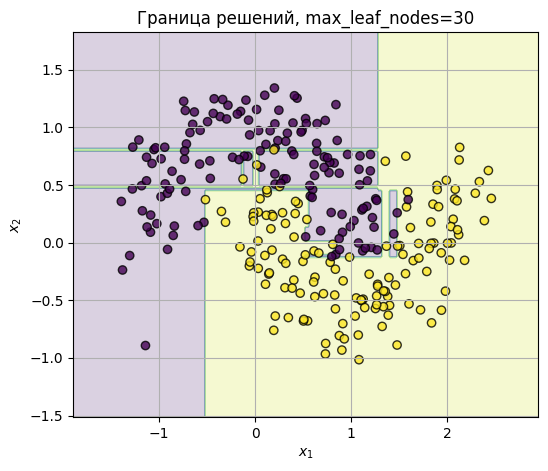

max_leaf_nodes = None
  Глубина дерева: 9
  Число листьев: 24
  Accuracy (train): 1.0
  Accuracy (test):  0.9083333333333333



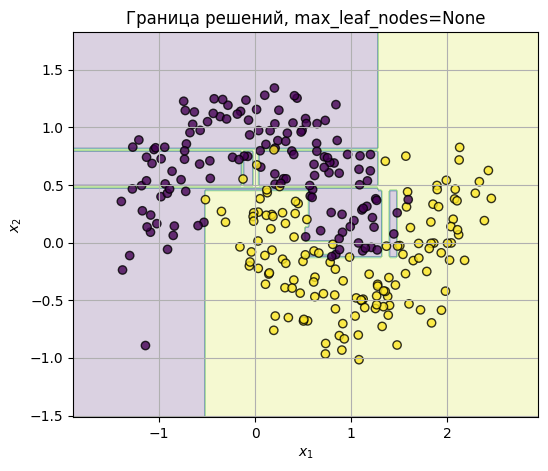

In [12]:
leaf_nodes_list = [3, 5, 10, 30, None]

for ln in leaf_nodes_list:
    tree = DecisionTreeClassifier(
        criterion="gini",
        max_leaf_nodes=ln,
        random_state=42
    )
    tree.fit(X_train, y_train)

    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    print(f"max_leaf_nodes = {ln}")
    print("  Глубина дерева:", tree.get_depth())
    print("  Число листьев:", tree.get_n_leaves())
    print("  Accuracy (train):", accuracy_score(y_train, y_train_pred))
    print("  Accuracy (test): ", accuracy_score(y_test, y_test_pred))
    print()

    title = f"Граница решений, max_leaf_nodes={ln}"
    plot_decision_boundary(tree, X_train, y_train, title=title)


Ограничение `max_leaf_nodes` даёт ещё один способ контролировать баланс между:

- сложностью модели (число листьев, глубина),
- качеством на обучении,
- обобщающей способностью на тесте.

Иногда удобнее мыслить в терминах «сколько листьев я хочу максимально разрешить дереву», а не в терминах глубины.


## 6. Работа с несбалансированными классами: `class_weight`

Во многих задачах данные несбалансированны: один класс встречается гораздо реже другого (например, отказ по кредиту, дефектный продукт и т.п.).

Если использовать стандартное дерево, оно будет оптимизировать среднюю ошибку и может «игнорировать» редкий класс.

Параметр `class_weight` позволяет изменить вклад ошибок по разным классам в критерий качества. Типичные значения:

- `None` — все классы равновесны;
- `"balanced"` — веса классов автоматически выбираются пропорционально обратным частотам классов;
- словарь вида `{0: w_0, 1: w_1, ...}` — пользовательские веса.


In [32]:
# Сгенерируем несбалансированный датасет
X_imb, y_imb = make_classification(
    n_samples=2000,
    n_features=25,
    n_informative=20,
    n_redundant=0,
    n_clusters_per_class=3,
    weights=[0.9, 0.1],  # класс 1 редкий
    flip_y=0.01,
    random_state=42
)

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(
    X_imb, y_imb, test_size=0.3, random_state=42, stratify=y_imb
)

print("Распределение классов в обучающей выборке:")
unique, counts = np.unique(y_imb_train, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  класс {cls}: {cnt} объектов")


Распределение классов в обучающей выборке:
  класс 0: 1256 объектов
  класс 1: 144 объектов


In [33]:
# Дерево без весов классов
tree_no_weights = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    random_state=42
)
tree_no_weights.fit(X_imb_train, y_imb_train)

y_pred_no_weights = tree_no_weights.predict(X_imb_test)

print("Без весов классов:")
print(classification_report(y_imb_test, y_pred_no_weights))


Без весов классов:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       538
           1       0.42      0.08      0.14        62

    accuracy                           0.89       600
   macro avg       0.66      0.53      0.54       600
weighted avg       0.85      0.89      0.86       600



In [34]:
# Дерево с автоматическими весами классов
tree_balanced = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    class_weight="balanced",
    random_state=42
)
tree_balanced.fit(X_imb_train, y_imb_train)

y_pred_balanced = tree_balanced.predict(X_imb_test)

print("С class_weight='balanced':")
print(classification_report(y_imb_test, y_pred_balanced))


С class_weight='balanced':
              precision    recall  f1-score   support

           0       0.94      0.75      0.83       538
           1       0.20      0.55      0.30        62

    accuracy                           0.73       600
   macro avg       0.57      0.65      0.56       600
weighted avg       0.86      0.73      0.78       600



По отчётам классификации можно увидеть, что при использовании `class_weight="balanced"`:

- точность по редкому классу (recall, precision, f1-score) обычно увеличивается;
- при этом общая accuracy может немного упасть, потому что модель начинает «серьёзнее относиться» к ошибкам на редком классе.

Это стандартный компромисс при работе с несбалансированными данными.

На деревьях и ансамблях деревьев параметр `class_weight` часто используется в задачах, где важнее не пропустить редкие, но критичные объекты (мошенничество, отказ оборудования, медицинские случаи и т.п.).


## 7. Другие важные параметры и связь с ансамблями

Мы уже рассмотрели основные гиперпараметры, которыми имеет смысл управлять в одиночном дереве:

- `criterion` — выбор критерия нечистоты узла (`"gini"` или `"entropy"`);
- `max_depth` — максимальная глубина дерева;
- `min_samples_split` — минимальное число объектов для дальнейшего разбиения узла;
- `min_samples_leaf` — минимальное число объектов в листе;
- `max_leaf_nodes` — ограничение числа листьев;
- `class_weight` — веса классов для несбалансированных данных;
- `random_state` — начальное состояние генератора случайных чисел (важно для воспроизводимости).

Есть ещё несколько параметров, которые становятся особенно важными в ансамблях деревьев (случайный лес, градиентный бустинг):

- `max_features` — сколько признаков рассматривать при каждом разбиении узла.  
  В одиночном дереве обычно оставляют `max_features=None` (все признаки).  
  В случайном лесу стандартно используют меньший поднабор признаков, чтобы деревья в ансамбле были более различными.

- `splitter` — стратегия выбора разбиения (`"best"` или `"random"`).  
  `"random"` даёт дополнительную случайность и может использоваться в случайных лесах и экстремально случайных деревьях.

На следующей практике логично перейти к ансамблям на основе деревьев:

- `RandomForestClassifier` / `RandomForestRegressor` — усреднение предсказаний многих случайных деревьев;
- `GradientBoostingClassifier` / `GradientBoostingRegressor` и более современные реализации бустинга — последовательное построение деревьев, исправляющих ошибки друг друга.

При этом все идеи, которые мы обсудили для одного дерева (критерии нечистоты, контроль глубины, минимальный размер листа, веса классов), остаются актуальными и помогают понимать и настраивать ансамбли.


# Интерпретация дерева

In [82]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

iris = load_iris()
X_iris = iris["data"]
y_iris = iris["target"]
feature_names = iris["feature_names"]
class_names = iris["target_names"]

feature_idx_to_use = [0, 2]
X = X_iris[:, feature_idx_to_use]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

X_train_i.shape, y_train_i.shape, y_test_i.shape, y_test_i.shape

((105, 2), (105,), (45,), (45,))

In [83]:
tree_small = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,       # специально ограничиваем глубину
    random_state=42
)
tree_small.fit(X_train_i, y_train_i)

print("Accuracy (test):", accuracy_score(y_test_i, tree_small.predict(X_test_i)))


Accuracy (test): 0.9111111111111111


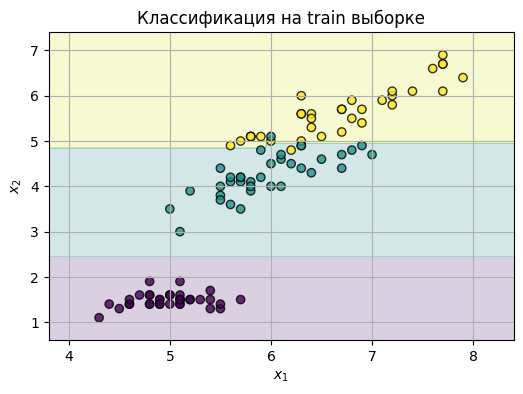

In [84]:
plot_decision_boundary(tree_small, X_train_i, y_train_i, title="Классификация на train выборке")

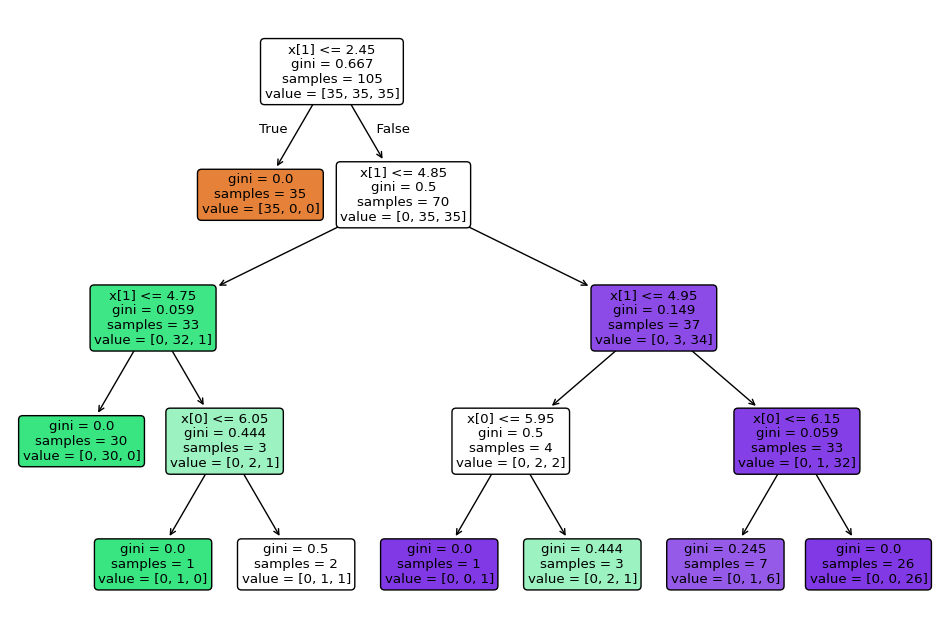

In [85]:
plt.figure(figsize=(12, 8))
plot_tree(
    tree_small,
    filled=True,
    rounded=True
)
plt.show()

In [86]:
tree_rules = export_text(tree_small)
print(tree_rules)

|--- feature_1 <= 2.45
|   |--- class: 0
|--- feature_1 >  2.45
|   |--- feature_1 <= 4.85
|   |   |--- feature_1 <= 4.75
|   |   |   |--- class: 1
|   |   |--- feature_1 >  4.75
|   |   |   |--- feature_0 <= 6.05
|   |   |   |   |--- class: 1
|   |   |   |--- feature_0 >  6.05
|   |   |   |   |--- class: 1
|   |--- feature_1 >  4.85
|   |   |--- feature_1 <= 4.95
|   |   |   |--- feature_0 <= 5.95
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  5.95
|   |   |   |   |--- class: 1
|   |   |--- feature_1 >  4.95
|   |   |   |--- feature_0 <= 6.15
|   |   |   |   |--- class: 2
|   |   |   |--- feature_0 >  6.15
|   |   |   |   |--- class: 2



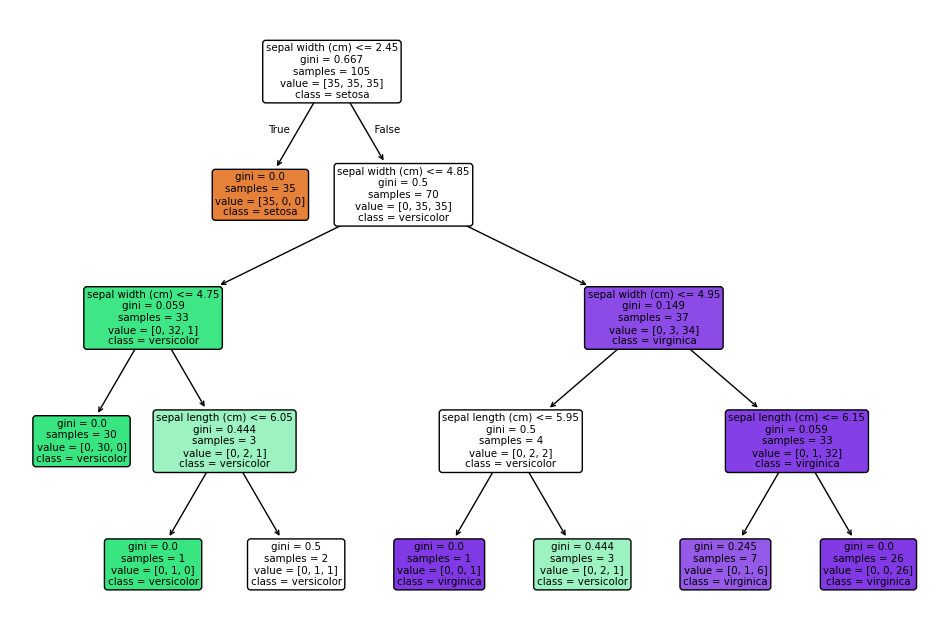

In [87]:
tree_small2 = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,       # специально ограничиваем глубину
    random_state=42
)
tree_small2.fit(X_iris, y_iris)

plt.figure(figsize=(12, 8))
plot_tree(
    tree_small,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.show()

# DecisionTreeRegressor

In [35]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


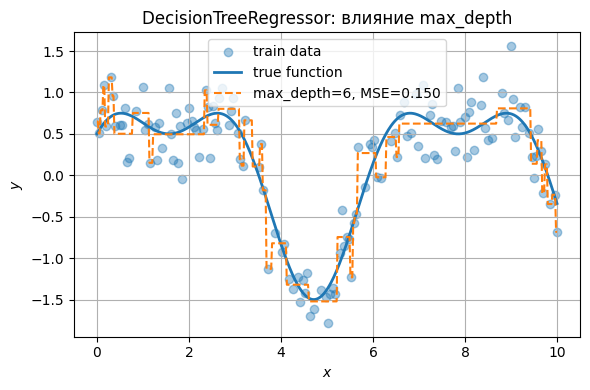

In [90]:
# Одномерная регрессия: гладкая функция + шум
rng = np.random.RandomState(42)

X = np.linspace(0, 10, 200).reshape(-1, 1)
y_true = np.sin(X[:, 0]) + 0.5 * np.cos(2 * X[:, 0])
y = y_true + rng.normal(scale=0.3, size=X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# depths = [2, 4, 6, None]
depths = [6]
X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_true_plot = np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0])

fig, ax = plt.subplots()
ax.scatter(X_train[:, 0], y_train, alpha=0.4, label="train data")

ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")

for d in depths:
    reg = DecisionTreeRegressor(max_depth=d, random_state=42)
    reg.fit(X_train, y_train)
    y_pred_plot = reg.predict(X_plot)
    y_pred_test = reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred_test)
    label = f"max_depth={d}, MSE={mse:.3f}"
    ax.plot(X_plot[:, 0], y_pred_plot, linewidth=1.5, linestyle="--", label=label)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_title("DecisionTreeRegressor: влияние max_depth")
ax.legend()
plt.tight_layout()
plt.show()


min_samples_leaf = 1
  MSE (train): 0.0
  MSE (test):  0.17321061255758485



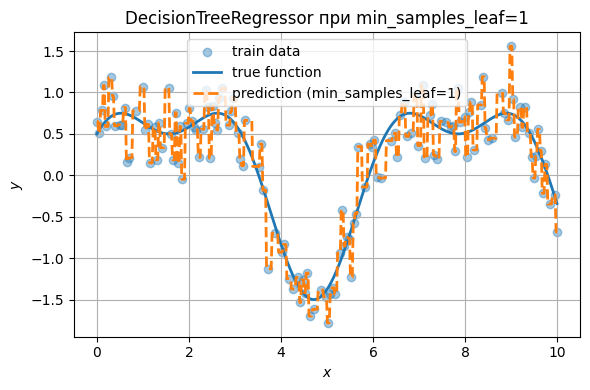

min_samples_leaf = 5
  MSE (train): 0.06631736863458691
  MSE (test):  0.10448480263179333



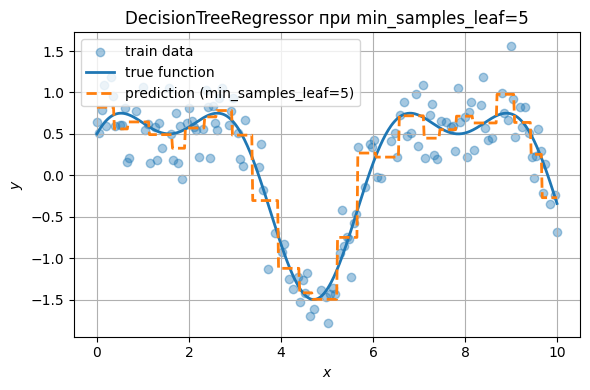

min_samples_leaf = 20
  MSE (train): 0.15416683187922525
  MSE (test):  0.22137280427955816



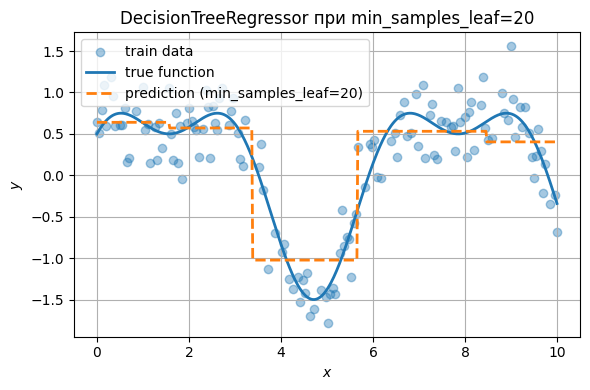

In [39]:
# Используем те же X_train, y_train, X_test, y_test
leaf_sizes = [1, 5, 20]

X_plot = np.linspace(0, 10, 500).reshape(-1, 1)
y_true_plot = np.sin(X_plot[:, 0]) + 0.5 * np.cos(2 * X_plot[:, 0])

for leaf in leaf_sizes:
    reg = DecisionTreeRegressor(
        max_depth=None,
        min_samples_leaf=leaf,
        random_state=42
    )
    reg.fit(X_train, y_train)

    y_pred_plot = reg.predict(X_plot)
    y_pred_train = reg.predict(X_train)
    y_pred_test = reg.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    print(f"min_samples_leaf = {leaf}")
    print("  MSE (train):", mse_train)
    print("  MSE (test): ", mse_test)
    print()

    fig, ax = plt.subplots()
    ax.scatter(X_train[:, 0], y_train, alpha=0.4, label="train data")
    ax.plot(X_plot[:, 0], y_true_plot, linewidth=2, label="true function")
    ax.plot(X_plot[:, 0], y_pred_plot, linewidth=2, linestyle="--",
            label=f"prediction (min_samples_leaf={leaf})")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_title(f"DecisionTreeRegressor при min_samples_leaf={leaf}")
    ax.legend()
    plt.tight_layout()
    plt.show()


In [40]:
# Многомерная регрессия: сравнение нескольких настроек дерева
X_reg, y_reg = make_regression(
    n_samples=1500,
    n_features=10,
    n_informative=5,
    noise=15.0,
    random_state=42
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

configs = [
    ("baseline", {"max_depth": None, "min_samples_leaf": 1}),
    ("shallow", {"max_depth": 3, "min_samples_leaf": 1}),
    ("regularized_leaf", {"max_depth": None, "min_samples_leaf": 20}),
    ("shallow+leaf", {"max_depth": 5, "min_samples_leaf": 10}),
]

results = []

for name, params in configs:
    reg = DecisionTreeRegressor(
        random_state=42,
        **params
    )
    reg.fit(Xr_train, yr_train)
    yr_pred_train = reg.predict(Xr_train)
    yr_pred_test = reg.predict(Xr_test)

    mse_train = mean_squared_error(yr_train, yr_pred_train)
    mse_test = mean_squared_error(yr_test, yr_pred_test)

    results.append((name, params, mse_train, mse_test))

print("Сравнение настроек DecisionTreeRegressor (MSE):")
for name, params, mse_tr, mse_te in results:
    print(f"{name:15s} | params={params}")
    print(f"  MSE train: {mse_tr:.3f}")
    print(f"  MSE test : {mse_te:.3f}")
    print()


Сравнение настроек DecisionTreeRegressor (MSE):
baseline        | params={'max_depth': None, 'min_samples_leaf': 1}
  MSE train: 0.000
  MSE test : 4469.651

shallow         | params={'max_depth': 3, 'min_samples_leaf': 1}
  MSE train: 7509.288
  MSE test : 7713.881

regularized_leaf | params={'max_depth': None, 'min_samples_leaf': 20}
  MSE train: 3035.666
  MSE test : 3991.003

shallow+leaf    | params={'max_depth': 5, 'min_samples_leaf': 10}
  MSE train: 3927.779
  MSE test : 4968.911

